In [1]:
!pip install scipy matplotlib


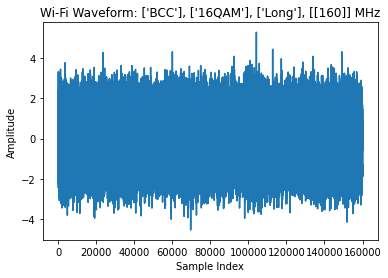

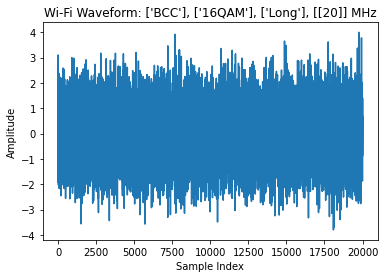

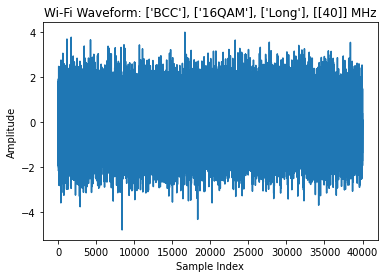

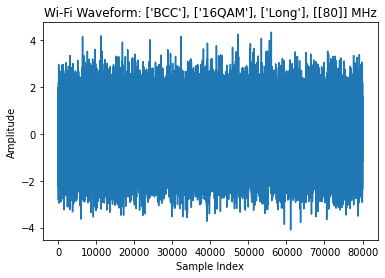

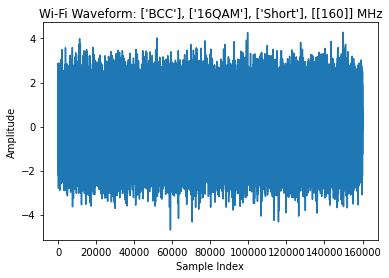

In [2]:
import os
import scipy.io
import matplotlib.pyplot as plt

# Directory where the .mat files are saved
output_dir = 'WiFi_Waveforms'

# List of .mat files
mat_files = [f for f in os.listdir(output_dir) if f.endswith('.mat')]

# Display the first 5 waveforms
for i, mat_file in enumerate(mat_files[:5]):
    # Load the .mat file
    mat_data = scipy.io.loadmat(os.path.join(output_dir, mat_file))
    
    # Extract waveform and configuration
    waveform = mat_data['waveform'].flatten()
    cfg = mat_data['cfg']
    
    # Extract configuration parameters
    channel_coding = cfg['ChannelCoding'][0][0]
    modulation = cfg['Modulation'][0][0]
    guard_interval = cfg['GuardInterval'][0][0]
    channel_bandwidth = cfg['ChannelBandwidth'][0][0]
    
    # Plot the waveform
    plt.figure()
    plt.plot(waveform)
    plt.title(f'Wi-Fi Waveform: {channel_coding}, {modulation}, {guard_interval}, {channel_bandwidth} MHz')
    plt.xlabel('Sample Index')
    plt.ylabel('Amplitude')
    plt.show()


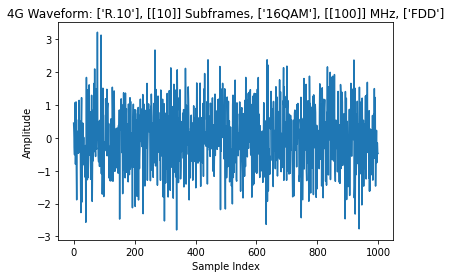

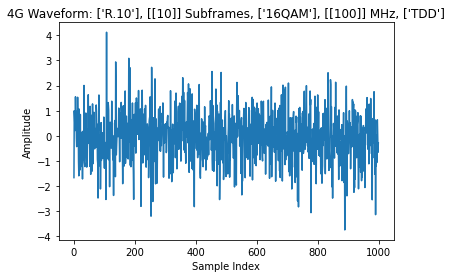

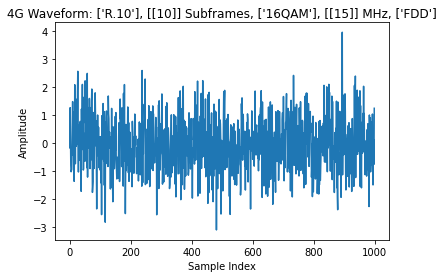

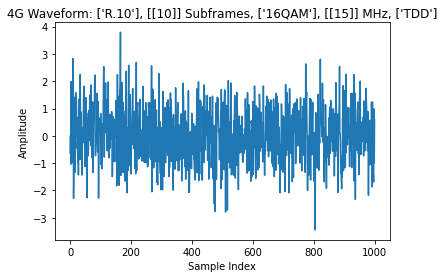

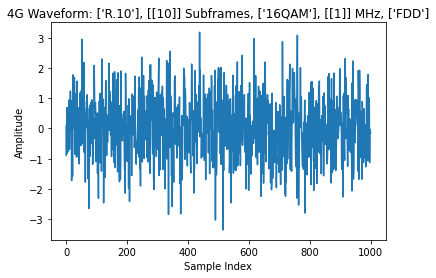

In [3]:
import os
import scipy.io
import matplotlib.pyplot as plt

# Directory where the 4G .mat files are saved
output_dir_4g = 'LTE_Waveforms'

# List of .mat files
mat_files_4g = [f for f in os.listdir(output_dir_4g) if f.endswith('.mat')]

# Display the first 5 waveforms for 4G
for i, mat_file in enumerate(mat_files_4g[:5]):
    # Load the .mat file
    mat_data = scipy.io.loadmat(os.path.join(output_dir_4g, mat_file))
    
    # Extract waveform and configuration
    waveform = mat_data['waveform'].flatten()
    cfg = mat_data['cfg']
    
    # Extract configuration parameters
    ref_channel = cfg['ReferenceChannel'][0][0]
    num_subframes = cfg['NumSubframes'][0][0]
    modulation = cfg['Modulation'][0][0]
    bandwidth = cfg['TransmissionBandwidth'][0][0]
    duplex_mode = cfg['DuplexMode'][0][0]
    
    # Plot the waveform
    plt.figure()
    plt.plot(waveform)
    plt.title(f'4G Waveform: {ref_channel}, {num_subframes} Subframes, {modulation}, {bandwidth} MHz, {duplex_mode}')
    plt.xlabel('Sample Index')
    plt.ylabel('Amplitude')
    plt.show()


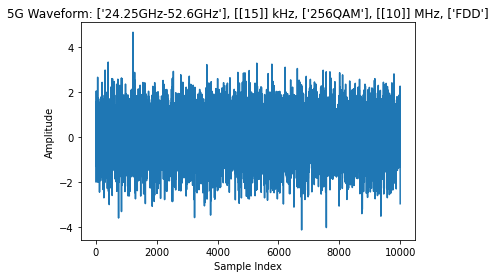

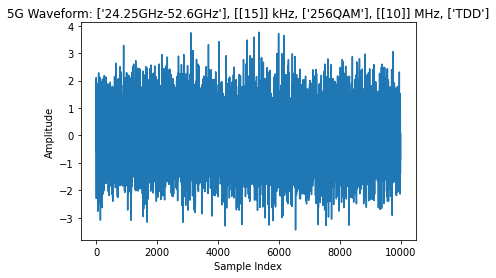

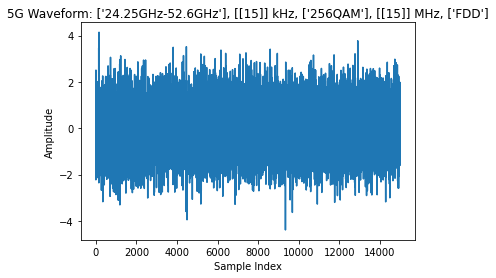

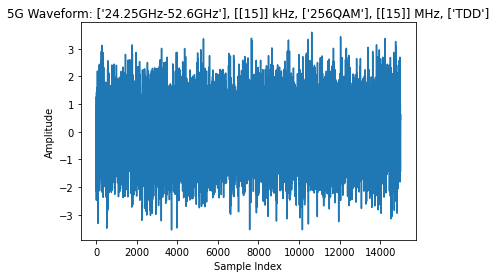

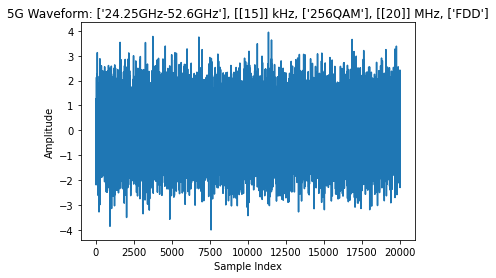

In [4]:
# Directory where the 5G .mat files are saved
output_dir_5g = '5G_Waveforms'

# List of .mat files
mat_files_5g = [f for f in os.listdir(output_dir_5g) if f.endswith('.mat')]

# Display the first 5 waveforms for 5G
for i, mat_file in enumerate(mat_files_5g[:5]):
    # Load the .mat file
    mat_data = scipy.io.loadmat(os.path.join(output_dir_5g, mat_file))
    
    # Extract waveform and configuration
    waveform = mat_data['waveform'].flatten()
    cfg = mat_data['cfg']
    
    # Extract configuration parameters
    frequency_range = cfg['FrequencyRange'][0][0]
    subcarrier_spacing = cfg['SubcarrierSpacing'][0][0]
    modulation = cfg['Modulation'][0][0]
    bandwidth = cfg['ChannelBandwidth'][0][0]
    duplex_mode = cfg['DuplexMode'][0][0]
    
    # Plot the waveform
    plt.figure()
    plt.plot(waveform)
    plt.title(f'5G Waveform: {frequency_range}, {subcarrier_spacing} kHz, {modulation}, {bandwidth} MHz, {duplex_mode}')
    plt.xlabel('Sample Index')
    plt.ylabel('Amplitude')
    plt.show()


# Preprocessing waveforms

In [46]:
import os
import numpy as np
import scipy.io
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# Function to load waveform data
def load_waveform_data(output_dir):
    # List of .mat files
    mat_files = [f for f in os.listdir(output_dir) if f.endswith('.mat')]
    waveforms = []
    configs = []
    
    # Load waveforms and configurations
    for mat_file in mat_files:
        mat_data = scipy.io.loadmat(os.path.join(output_dir, mat_file))
        waveforms.append(mat_data['waveform'].flatten())
        configs.append(mat_data['cfg'])
    
    return waveforms, configs

# Function to combine waveforms with equal channel gain and SNR
def combine_waveforms(waveform1, waveform2):
    combined = (waveform1 + waveform2) / 2
    return combined

# Function to segment waveforms into sequences of 512 I/Q pairs
def segment_waveforms(waveforms, segment_length=512):
    sequences = []
    for waveform in waveforms:
        num_samples = len(waveform)
        for start in range(0, num_samples - segment_length + 1, segment_length):
            segment = waveform[start:start + segment_length]
            sequences.append(segment)
    
    return np.array(sequences)

# Load and segment 4G waveforms
output_dir_4g = 'LTE_Waveforms'
waveforms_4g, _ = load_waveform_data(output_dir_4g)
sequences_4g = segment_waveforms(waveforms_4g)

# Load and segment 5G waveforms
output_dir_5g = '5G_Waveforms'
waveforms_5g, _ = load_waveform_data(output_dir_5g)
sequences_5g = segment_waveforms(waveforms_5g)

# Load and segment Wi-Fi waveforms
output_dir_wifi = 'WiFi_Waveforms'
waveforms_wifi, _ = load_waveform_data(output_dir_wifi)
sequences_wifi = segment_waveforms(waveforms_wifi)



In [30]:
print(sequences_wifi.shape)
print(sequences_5g.shape) 
print(sequences_4g.shape)

(11700, 512)
(13572, 512)
(4860, 512)


Ensure that all the data have the same shape 

In [34]:
import numpy as np

# Function to augment smaller datasets to match the target size
def augment_data(data, target_size):
    current_size = data.shape[0]
    if current_size < target_size:
        # Calculate the number of times to repeat the dataset
        repeats = target_size // current_size
        remainder = target_size % current_size
        
        # Repeat the data
        augmented_data = np.tile(data, (repeats, 1))
        
        # Add the remainder if necessary
        if remainder > 0:
            augmented_data = np.vstack((augmented_data, data[:remainder]))
    else:
        augmented_data = data
    
    return augmented_data

# Target size (same as the largest dataset)
target_size = 13572

# Augment the smaller datasets
sequences_4g = augment_data(sequences_4g, target_size)
sequences_wifi = augment_data(sequences_wifi, target_size)

# Verify the shapes
print("4G shape:", sequences_4g.shape)
print("Wi-Fi shape:", sequences_wifi.shape)
print("5G shape:", sequences_5g.shape)

4G shape: (13572, 512)
Wi-Fi shape: (13572, 512)
5G shape: (13572, 512)


Generate double and triple mixtures 

In [35]:
# Function to combine sequences
def combine_sequences(seq1, seq2):
    combined = (seq1 + seq2) / 2
    return combined

# Generate double-mixtures
wifi_lte_sequences = np.array([combine_sequences(s1, s2) for s1, s2 in zip(sequences_wifi, sequences_4g)])
wifi_5g_sequences = np.array([combine_sequences(s1, s2) for s1, s2 in zip(sequences_wifi, sequences_5g)])
lte_5g_sequences = np.array([combine_sequences(s1, s2) for s1, s2 in zip(sequences_4g, sequences_5g)])

# Generate triple-mixtures
wifi_lte_5g_sequences = np.array([combine_sequences(combine_sequences(s1, s2), s3) for s1, s2, s3 in zip(sequences_wifi, sequences_4g, sequences_5g)])

# Generate labels
labels_wifi_lte = np.full(len(wifi_lte_sequences), 3)
labels_wifi_5g = np.full(len(wifi_5g_sequences), 4)
labels_lte_5g = np.full(len(lte_5g_sequences), 5)
labels_wifi_lte_5g = np.full(len(wifi_lte_5g_sequences), 6)

# Combine all sequences and labels
all_sequences = np.concatenate((sequences_4g, sequences_5g, sequences_wifi, wifi_lte_sequences, wifi_5g_sequences, lte_5g_sequences, wifi_lte_5g_sequences), axis=0)
all_labels = np.concatenate((np.zeros(len(sequences_4g)), np.ones(len(sequences_5g)), np.full(len(sequences_wifi), 2), labels_wifi_lte, labels_wifi_5g, labels_lte_5g, labels_wifi_lte_5g), axis=0)


# train the model

In [38]:

# Split into training and testing datasets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(all_sequences, all_labels, test_size=0.2, random_state=42)

# Reshape the data for Conv1D layer
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

# Convert labels to one-hot encoding
y_train = tf.keras.utils.to_categorical(y_train, 7)
y_test = tf.keras.utils.to_categorical(y_test, 7)

print(f"Training data shape: {X_train.shape}")
print(f"Testing data shape: {X_test.shape}")

Training data shape: (76003, 512, 1)
Testing data shape: (19001, 512, 1)


In [37]:
import os
import numpy as np
import scipy.io
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, LSTM, Dense, Softmax

In [39]:



# Define the model
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(512, 1)))
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(tf.keras.layers.Reshape((64, -1)))
model.add(LSTM(100))
model.add(Dense(100, activation='relu'))
model.add(Dense(7))
model.add(Softmax())

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.2)

# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Loss: {loss}")
print(f"Test Accuracy: {accuracy}")



Epoch 1/10
1901/1901 [==============================] - 168s 86ms/step - loss: 1.0740 - accuracy: 0.3936 - val_loss: 0.9694 - val_accuracy: 0.4221
Epoch 2/10
1901/1901 [==============================] - 178s 94ms/step - loss: 0.9838 - accuracy: 0.4165 - val_loss: 0.9588 - val_accuracy: 0.4298
Epoch 3/10
1901/1901 [==============================] - 253s 133ms/step - loss: 0.9818 - accuracy: 0.4206 - val_loss: 0.9909 - val_accuracy: 0.4235
Epoch 4/10
1901/1901 [==============================] - 178s 94ms/step - loss: 0.9801 - accuracy: 0.4216 - val_loss: 0.9807 - val_accuracy: 0.4206
Epoch 5/10
1901/1901 [==============================] - 431s 227ms/step - loss: 0.9763 - accuracy: 0.4217 - val_loss: 0.9608 - val_accuracy: 0.4300
Epoch 6/10
1901/1901 [==============================] - 397s 209ms/step - loss: 0.9753 - accuracy: 0.4227 - val_loss: 0.9575 - val_accuracy: 0.4227
Epoch 7/10
1901/1901 [==============================] - 397s 209ms/step - loss: 0.9716 - accuracy: 0.4230 - val_los

In [40]:
# Predict the labels for the test set
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)


594/594 [==============================] - 16s 25ms/step


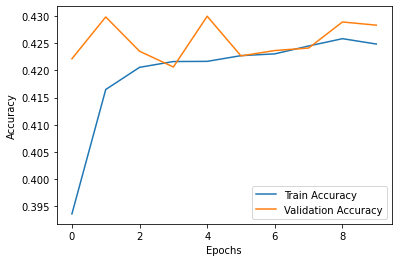

In [41]:


# Plot the training and validation accuracy
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

594/594 [==============================] - 14s 23ms/step


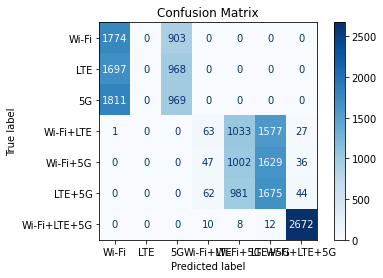

In [42]:
# Predict the labels for the test set
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

# Compute the confusion matrix
cm = confusion_matrix(y_true, y_pred_classes, labels=[0, 1, 2, 3, 4, 5, 6])
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Wi-Fi', 'LTE', '5G', 'Wi-Fi+LTE', 'Wi-Fi+5G', 'LTE+5G', 'Wi-Fi+LTE+5G'])

# Plot the confusion matrix
cm_display.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

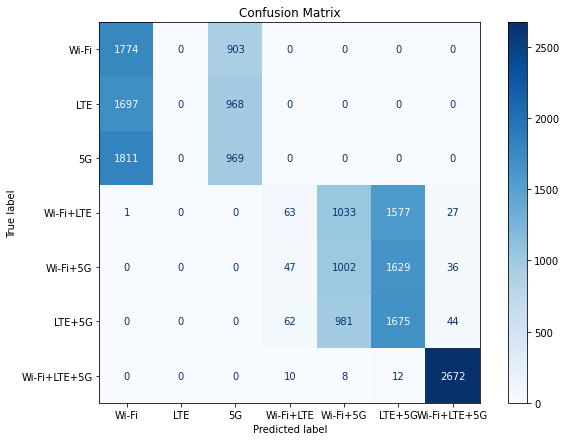

In [45]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# Compute the confusion matrix
cm = confusion_matrix(y_true, y_pred_classes, labels=[0, 1, 2, 3, 4, 5, 6])

# Plot the confusion matrix
plt.figure(figsize=(10, 7))
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Wi-Fi', 'LTE', '5G', 'Wi-Fi+LTE', 'Wi-Fi+5G', 'LTE+5G', 'Wi-Fi+LTE+5G'])
cm_display.plot(cmap=plt.cm.Blues, ax=plt.gca())
plt.title('Confusion Matrix')


plt.show()

# Impact of STFT

In [48]:
import os
import numpy as np
import scipy.io
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# Function to load waveform data
def load_waveform_data(output_dir):
    # List of .mat files
    mat_files = [f for f in os.listdir(output_dir) if f.endswith('.mat')]
    waveforms = []
    configs = []
    
    # Load waveforms and configurations
    for mat_file in mat_files:
        mat_data = scipy.io.loadmat(os.path.join(output_dir, mat_file))
        waveforms.append(mat_data['waveform'].flatten())
        configs.append(mat_data['cfg'])
    
    return waveforms, configs

# Function to combine waveforms with equal channel gain and SNR
def combine_waveforms(waveform1, waveform2):
    combined = (waveform1 + waveform2) / 2
    return combined

# Function to segment waveforms into sequences of 512 I/Q pairs
def segment_waveforms(waveforms, segment_length=512):
    sequences = []
    for waveform in waveforms:
        num_samples = len(waveform)
        for start in range(0, num_samples - segment_length + 1, segment_length):
            segment = waveform[start:start + segment_length]
            sequences.append(segment)
    
    return np.array(sequences)

# Load and segment 4G waveforms
output_dir_4g = 'LTE_Waveforms'
waveforms_4g, _ = load_waveform_data(output_dir_4g)
sequences_4g = segment_waveforms(waveforms_4g)

# Load and segment 5G waveforms
output_dir_5g = '5G_Waveforms'
waveforms_5g, _ = load_waveform_data(output_dir_5g)
sequences_5g = segment_waveforms(waveforms_5g)

# Load and segment Wi-Fi waveforms
output_dir_wifi = 'WiFi_Waveforms'
waveforms_wifi, _ = load_waveform_data(output_dir_wifi)
sequences_wifi = segment_waveforms(waveforms_wifi)


# Function to augment smaller datasets to match the target size
def augment_data(data, target_size):
    current_size = data.shape[0]
    if current_size < target_size:
        # Calculate the number of times to repeat the dataset
        repeats = target_size // current_size
        remainder = target_size % current_size
        
        # Repeat the data
        augmented_data = np.tile(data, (repeats, 1))
        
        # Add the remainder if necessary
        if remainder > 0:
            augmented_data = np.vstack((augmented_data, data[:remainder]))
    else:
        augmented_data = data
    
    return augmented_data

# Target size (same as the largest dataset)
target_size = 13572

# Augment the smaller datasets
sequences_4g = augment_data(sequences_4g, target_size)
sequences_wifi = augment_data(sequences_wifi, target_size)
"""
# Verify the shapes
print("4G shape:", sequences_4g.shape)
print("Wi-Fi shape:", sequences_wifi.shape)
print("5G shape:", sequences_5g.shape)
"""
# Function to combine sequences
def combine_sequences(seq1, seq2):
    combined = (seq1 + seq2) / 2
    return combined

# Generate double-mixtures
wifi_lte_sequences = np.array([combine_sequences(s1, s2) for s1, s2 in zip(sequences_wifi, sequences_4g)])
wifi_5g_sequences = np.array([combine_sequences(s1, s2) for s1, s2 in zip(sequences_wifi, sequences_5g)])
lte_5g_sequences = np.array([combine_sequences(s1, s2) for s1, s2 in zip(sequences_4g, sequences_5g)])

# Generate triple-mixtures
wifi_lte_5g_sequences = np.array([combine_sequences(combine_sequences(s1, s2), s3) for s1, s2, s3 in zip(sequences_wifi, sequences_4g, sequences_5g)])

# Generate labels
labels_wifi_lte = np.full(len(wifi_lte_sequences), 3)
labels_wifi_5g = np.full(len(wifi_5g_sequences), 4)
labels_lte_5g = np.full(len(lte_5g_sequences), 5)
labels_wifi_lte_5g = np.full(len(wifi_lte_5g_sequences), 6)

# Combine all sequences and labels
all_sequences = np.concatenate((sequences_4g, sequences_5g, sequences_wifi, wifi_lte_sequences, wifi_5g_sequences, lte_5g_sequences, wifi_lte_5g_sequences), axis=0)
all_labels = np.concatenate((np.zeros(len(sequences_4g)), np.ones(len(sequences_5g)), np.full(len(sequences_wifi), 2), labels_wifi_lte, labels_wifi_5g, labels_lte_5g, labels_wifi_lte_5g), axis=0)


In [50]:
import scipy.io
import matplotlib.pyplot as plt
from scipy.signal import stft
# Apply STFT
def apply_stft(sequences, nperseg=256):
    stft_sequences = []
    for seq in sequences:
        f, t, Zxx = stft(seq, nperseg=nperseg)
        stft_sequences.append(np.abs(Zxx))
    return np.array(stft_sequences)

stft_sequences = apply_stft(all_sequences)

In [52]:
stft_sequences.shape

(95004, 129, 5)

In [60]:
X_train, X_test, y_train, y_test = train_test_split(stft_sequences, all_labels, test_size=0.2, random_state=42)

# Reshape for CNN input
X_train = X_train[..., np.newaxis]
X_test = X_test[..., np.newaxis]
print(f"Training data shape: {X_train.shape}")
print(f"Testing data shape: {X_test.shape}")

Training data shape: (76003, 129, 5, 1)
Testing data shape: (19001, 129, 5, 1)


In [66]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, LSTM, Dense, Softmax, Reshape, TimeDistributed# Split the data into training and testing sets

# Build the model with LSTM layer after Flatten
model = Sequential([
    Conv2D(16, (3, 3), activation='relu', padding='same', input_shape=(129, 5, 1)),
    MaxPooling2D((2, 2), padding='same'),
    Conv2D(32, (3, 3), activation='relu', padding='same'),
    MaxPooling2D((2, 2), padding='same'),
    Flatten(),
    Reshape((32, -1)),  # Adjust the reshape dimensions according to the output from Flatten
    LSTM(128),
    Dense(128, activation='relu'),
    Dense(7, activation='softmax')
])


model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train, epochs=10, validation_data=(X_test, y_test))

# Evaluate the model
y_pred = model.predict(X_test)
y_pred_labels = np.argmax(y_pred, axis=1)


Epoch 1/10
2376/2376 [==============================] - 75s 30ms/step - loss: 1.0383 - accuracy: 0.4069 - val_loss: 0.9725 - val_accuracy: 0.4217
Epoch 2/10
2376/2376 [==============================] - 69s 29ms/step - loss: 0.9853 - accuracy: 0.4212 - val_loss: 0.9645 - val_accuracy: 0.4233
Epoch 3/10
2376/2376 [==============================] - 72s 30ms/step - loss: 0.9811 - accuracy: 0.4228 - val_loss: 0.9699 - val_accuracy: 0.4269
Epoch 4/10
2376/2376 [==============================] - 71s 30ms/step - loss: 0.9794 - accuracy: 0.4225 - val_loss: 0.9886 - val_accuracy: 0.4179
Epoch 5/10
2376/2376 [==============================] - 72s 30ms/step - loss: 0.9758 - accuracy: 0.4232 - val_loss: 0.9799 - val_accuracy: 0.4206
Epoch 6/10
2376/2376 [==============================] - 72s 30ms/step - loss: 0.9780 - accuracy: 0.4220 - val_loss: 0.9919 - val_accuracy: 0.4213
Epoch 7/10
2376/2376 [==============================] - 72s 30ms/step - loss: 0.9731 - accuracy: 0.4240 - val_loss: 0.9710 -

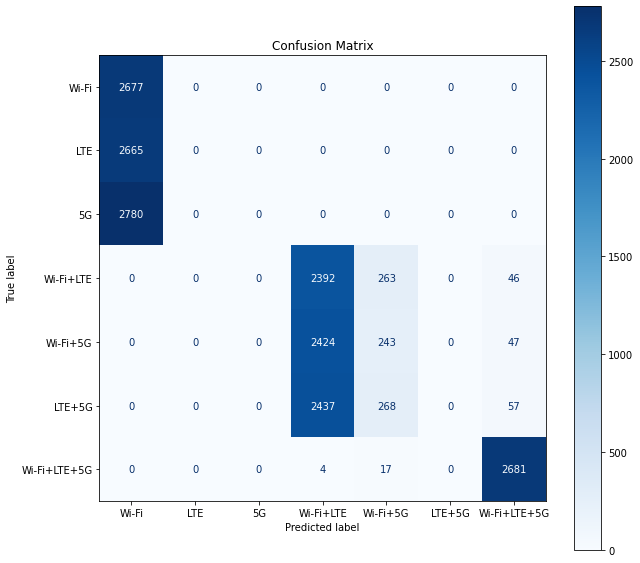

In [71]:
# Compute the confusion matrix
cm = confusion_matrix(y_true, y_pred_labels, labels=[0, 1, 2, 3, 4, 5, 6])

# Plot the confusion matrix
plt.figure(figsize=(10, 10))
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Wi-Fi', 'LTE', '5G', 'Wi-Fi+LTE', 'Wi-Fi+5G', 'LTE+5G', 'Wi-Fi+LTE+5G'])
cm_display.plot(cmap=plt.cm.Blues, ax=plt.gca())
plt.title('Confusion Matrix')


plt.show()